In [1]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

TensorFlow 2.x selected.


In [2]:
import pandas as pd
import numpy as np
from keras import layers, optimizers, models, datasets, callbacks, applications, Model, losses
from keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import cv2 as cv

from sklearn.svm import SVC

import requests

Using TensorFlow backend.


# Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
X = np.load("/content/drive/My Drive/AML/Assignment/Assignment_4/X.npy")
y = np.load("/content/drive/My Drive/AML/Assignment/Assignment_4/Y.npy")

In [5]:
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))

X shape: (2062, 64, 64)
y shape: (2062, 10)


## Cambio spazio colore e shape

In [0]:
X_rgb = np.zeros(shape=(2062,64,64,3))
for i in range(len(X)):
    X_rgb[i] = cv.cvtColor(X[i],cv.COLOR_GRAY2RGB)

In [0]:
IMG_SIZE = 64
X_rgb = X_rgb/255.0
y = np.argmax(y, axis=1)

In [11]:
print("X shape: " + str(X_rgb.shape))
print("y shape: " + str(y.shape))

X shape: (2062, 64, 64, 3)
y shape: (2062,)


## Sistemo le label

In [0]:
y_new = np.zeros(len(y))
y_new[y == 0] = int(9)
y_new[y == 1] = int(0)
y_new[y == 2] = int(7)
y_new[y == 3] = int(6)
y_new[y == 4] = int(1)
y_new[y == 5] = int(8)
y_new[y == 6] = int(4)
y_new[y == 7] = int(3)
y_new[y == 8] = int(2)
y_new[y == 9] = int(5)


y = y_new

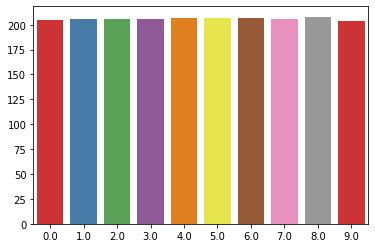

In [0]:
target = pd.DataFrame(y)
target.columns = ["TARGET"]

sns.barplot(target["TARGET"].value_counts().index, target["TARGET"].value_counts().values, palette="Set1")


In [0]:
target["TARGET"].value_counts()

8.0    208
5.0    207
4.0    207
6.0    207
2.0    206
3.0    206
1.0    206
7.0    206
0.0    205
9.0    204
Name: TARGET, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_rgb, y, stratify = y ,test_size=0.15, random_state=42)

# Carico VGG19


In [0]:
vgg_base = applications.vgg19.VGG19(input_shape = (64, 64, 3),
                                    weights='imagenet', 
                                    include_top = False)

In [15]:
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
for layer in vgg_base.layers:
    layer.trainable = False

## Taglio al secondo blocco

In [16]:
x = Model(inputs=vgg_base.input, outputs=vgg_base.get_layer('block2_pool').output).output
x = layers.Flatten()(x)

net = Model(input = vgg_base.input, output = x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [17]:
net.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [18]:
X_train_feature = net.predict(X_train, batch_size=128, verbose = 1)

1752/1752 [==============================] - 2s 1ms/step


### Creazione e train SVM

In [0]:
param_grid = {"C" : [5, 10, 25, 50], "gamma" : [0.005, 0.015, 0.02, 0.1]}

clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, cv = 2)

In [0]:
clf = clf.fit(X_train_feature, y_train)

print("I parametri migliori risultano C : " + str(clf.best_estimator_.C) + " e gamma:" + str(clf.best_estimator_.gamma))

I parametri migliori risultano C : 5 e gamma:0.1


In [0]:
y_train_pred = clf.predict(X_train_feature)

In [0]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       174
         1.0       1.00      1.00      1.00       175
         2.0       1.00      1.00      1.00       175
         3.0       1.00      0.99      1.00       175
         4.0       1.00      1.00      1.00       176
         5.0       1.00      1.00      1.00       176
         6.0       1.00      1.00      1.00       176
         7.0       0.99      1.00      1.00       175
         8.0       1.00      1.00      1.00       177
         9.0       1.00      1.00      1.00       173

    accuracy                           1.00      1752
   macro avg       1.00      1.00      1.00      1752
weighted avg       1.00      1.00      1.00      1752



### Test

In [0]:
test_feature = net.predict(X_test, batch_size=128, verbose = 1)

310/310 [==============================] - 5s 15ms/step


In [0]:
y_pred = clf.predict(test_feature)

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        31
         1.0       1.00      0.97      0.98        31
         2.0       0.91      0.97      0.94        31
         3.0       1.00      1.00      1.00        31
         4.0       0.87      0.84      0.85        31
         5.0       1.00      1.00      1.00        31
         6.0       0.90      0.90      0.90        31
         7.0       0.86      0.81      0.83        31
         8.0       0.88      0.97      0.92        31
         9.0       0.94      0.97      0.95        31

    accuracy                           0.94       310
   macro avg       0.94      0.94      0.94       310
weighted avg       0.94      0.94      0.94       310



## Taglio al terzo blocco

In [0]:
x = Model(inputs=vgg_base.input, outputs=vgg_base.get_layer('block3_pool').output).output
x = layers.Flatten()(x)

net = Model(input = vgg_base.input, output = x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [0]:
net.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

In [0]:
X_train_feature = net.predict(X_train, batch_size=128, verbose = 1)

1752/1752 [==============================] - 48s 27ms/step


### Creazione e train SVM

In [0]:
param_grid = {"C" : [5, 10, 25, 50], "gamma" : [0.005, 0.015, 0.02, 0.1, 0.5]}

clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, cv = 2)

In [0]:
clf = clf.fit(X_train_feature, y_train)

print("I parametri migliori risultano C : " + str(clf.best_estimator_.C) + " e gamma:" + str(clf.best_estimator_.gamma))


In [0]:
y_train_pred = clf.predict(X_train_feature)

In [0]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       174
         1.0       1.00      1.00      1.00       175
         2.0       1.00      0.99      1.00       175
         3.0       0.99      0.99      0.99       175
         4.0       1.00      0.99      1.00       176
         5.0       1.00      1.00      1.00       176
         6.0       0.99      1.00      1.00       176
         7.0       0.99      1.00      1.00       175
         8.0       1.00      1.00      1.00       177
         9.0       1.00      1.00      1.00       173

    accuracy                           1.00      1752
   macro avg       1.00      1.00      1.00      1752
weighted avg       1.00      1.00      1.00      1752



### Test

In [0]:
test_feature = net.predict(X_test, batch_size=128, verbose = 1)

310/310 [==============================] - 9s 28ms/step


In [0]:
y_pred = clf.predict(test_feature)

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        31
         1.0       1.00      1.00      1.00        31
         2.0       0.94      0.97      0.95        31
         3.0       0.97      1.00      0.98        31
         4.0       0.91      0.94      0.92        31
         5.0       1.00      1.00      1.00        31
         6.0       0.88      0.94      0.91        31
         7.0       0.96      0.87      0.92        31
         8.0       1.00      0.94      0.97        31
         9.0       0.97      1.00      0.98        31

    accuracy                           0.96       310
   macro avg       0.96      0.96      0.96       310
weighted avg       0.96      0.96      0.96       310



## Taglio al quarto blocco

In [19]:
x = Model(inputs=vgg_base.input, outputs=vgg_base.get_layer('block4_pool').output).output
x = layers.Flatten()(x)

net = Model(input = vgg_base.input, output = x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [20]:
net.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

### Creazione e train SVM

In [21]:
X_train_feature = net.predict(X_train, batch_size=128, verbose = 1)

1752/1752 [==============================] - 1s 472us/step


In [0]:
param_grid = {"C" : [10, 20, 50], "gamma" : [0.015, 0.02, 0.1, 0.5, 1]}

clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, cv = 2)


In [26]:
clf = clf.fit(X_train_feature, y_train)

print("I parametri migliori risultano C : " + str(clf.best_estimator_.C) + " e gamma:" + str(clf.best_estimator_.gamma))

I parametri migliori risultano C : 20 e gamma:0.5


In [0]:
y_train_pred = clf.predict(X_train_feature)

In [28]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       174
         1.0       1.00      1.00      1.00       175
         2.0       1.00      0.99      1.00       175
         3.0       0.99      0.99      0.99       175
         4.0       1.00      0.99      1.00       176
         5.0       1.00      1.00      1.00       176
         6.0       0.99      1.00      1.00       176
         7.0       0.99      1.00      1.00       175
         8.0       1.00      1.00      1.00       177
         9.0       1.00      1.00      1.00       173

    accuracy                           1.00      1752
   macro avg       1.00      1.00      1.00      1752
weighted avg       1.00      1.00      1.00      1752



### Test

In [29]:
test_feature = net.predict(X_test, batch_size=128, verbose = 1)

310/310 [==============================] - 0s 838us/step


In [0]:
y_pred = clf.predict(test_feature)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        31
         1.0       0.97      1.00      0.98        31
         2.0       0.90      0.90      0.90        31
         3.0       0.94      1.00      0.97        31
         4.0       0.87      0.87      0.87        31
         5.0       1.00      1.00      1.00        31
         6.0       0.85      0.90      0.88        31
         7.0       0.86      0.81      0.83        31
         8.0       0.97      0.90      0.93        31
         9.0       0.94      0.94      0.94        31

    accuracy                           0.93       310
   macro avg       0.93      0.93      0.93       310
weighted avg       0.93      0.93      0.93       310

